In [2]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json


# Point this path to where you unzipped the clinical_trial_risk repository
REPO_DIR = "/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/projects_client/clinical_trial_risk"
sys.path.append(REPO_DIR + "/front_end")

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


In [3]:
MODELS_DIR = REPO_DIR + '/front_end/models/'

In [4]:
from util.page_tokeniser import tokenise_pages

In [5]:
from processors.sap_extractor_spacy import SapExtractorSpacy

2022-11-19 13:38:13.720511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 13:38:13.864615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 13:38:13.864632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-19 13:38:13.897355: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-19 13:38:14.566883: W tensorflow/stream_executor/platform/de

In [6]:
from processors.sap_extractor import SapExtractor

In [7]:
from processors.sap_extractor_document_level_naive_bayes import SapExtractorDocumentLevel

In [8]:
sap_extractor_spacy = SapExtractorSpacy(MODELS_DIR + "spacy-textcat-sap-01-model-best")

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [9]:
sap_extractor = SapExtractor(MODELS_DIR + "sap_classifier.pkl.bz2")

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:32

In [32]:
sap_extractor_document_level = SapExtractorDocumentLevel(MODELS_DIR + "sap_classifier_document_level.pkl.bz2")

Initialising SAP document level classifier /media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/projects_client/clinical_trial_risk/front_end/models/sap_classifier_document_level.pkl.bz2


/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:32

In [11]:
df_train = df_annotations[df_annotations.train_val == "val"]

In [12]:
df_train_small = df_train.sample(100)

In [13]:
!ls ../../data/ctgov/

02_MakePickleFile.ipynb		       preprocess.py
02_MakePickleFile-small-testing.ipynb  protocols.pkl.gz
03_MakePickleFile_Tokenised.ipynb      protocols_small_test.pkl.gz
annotations			       raw_protocols


In [14]:
texts =[]
for i in range(len(df_train_small)):
    file_name = df_train_small.file.iloc[i]

    with open("/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/data_open/read_ctgov_data/json/" + file_name + ".json", "r", encoding="utf-8") as f:
        pages = json.load(f)
    texts.append(pages)
df_train_small["pages"] = texts

In [33]:
pred1 = []
pred2 = []
pred3 = []

y1 = []
y2 = []
y3 = []
y4 = []
for idx in range(len(df_train_small)):
    tokenised_pages = tokenise_pages(df_train_small.pages.iloc[idx])
    
    sap_to_pages = sap_extractor.process(tokenised_pages)
    pred1.append(sap_to_pages["prediction"])
    y1.append(sap_to_pages["score"])
    
    sap_to_pages_spacy = sap_extractor_spacy.process(tokenised_pages)
    pred2.append(sap_to_pages_spacy["prediction"])
    y2.append(sap_to_pages_spacy["probas"])
    
    sap_to_pages_doc = sap_extractor_document_level.process(tokenised_pages)
    pred3.append(sap_to_pages_doc["prediction"])
    y3.append(sap_to_pages_doc["score"])
    
    y4.append(np.mean([sap_to_pages_doc["score"],sap_to_pages["score"] ]))

In [34]:
df_train_small["y1"] = y1
df_train_small["y2"] = y2
df_train_small["y3"] = y3
df_train_small["y4"] = y4

In [35]:
df_train_small["y1_pred"] = pred1
df_train_small["y2_pred"] = pred2
df_train_small["y3_pred"] = pred3

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

''

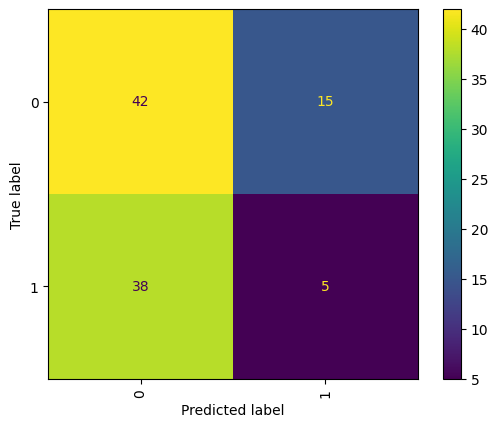

In [37]:
ConfusionMatrixDisplay.from_predictions(df_train_small.has_sap, df_train_small.y1_pred)
plt.xticks(rotation=90)
;

''

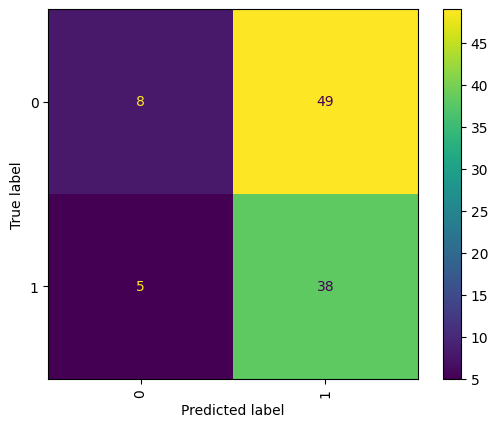

In [38]:
ConfusionMatrixDisplay.from_predictions(df_train_small.has_sap, df_train_small.y2_pred)
plt.xticks(rotation=90)
;

''

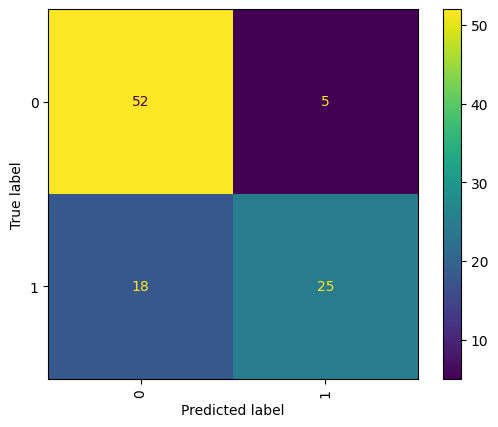

In [39]:
ConfusionMatrixDisplay.from_predictions(df_train_small.has_sap, df_train_small.y3_pred)
plt.xticks(rotation=90)
;

In [40]:
import matplotlib.pyplot as plt

In [41]:
df_train_small.has_sap.value_counts()

0    57
1    43
Name: has_sap, dtype: int64

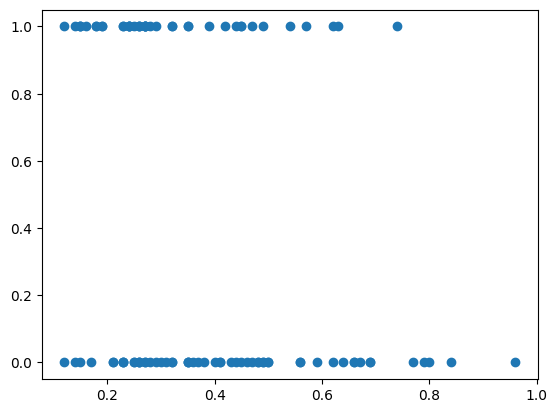

In [42]:
plt.scatter(df_train_small.y1, df_train_small.has_sap)

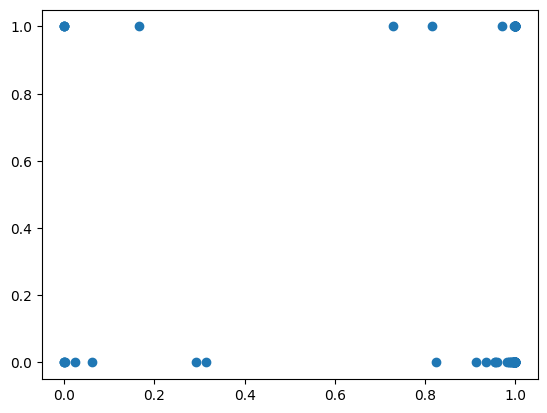

In [43]:
plt.scatter(df_train_small.y2, df_train_small.has_sap)

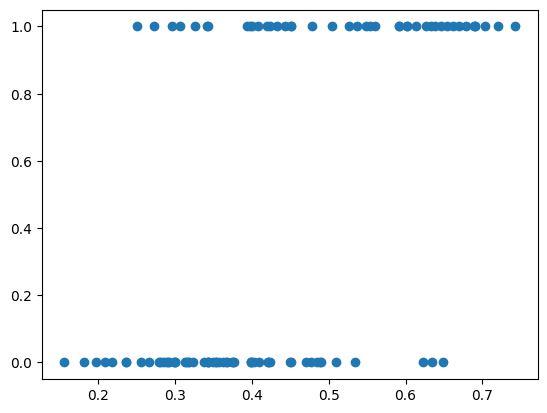

In [44]:
plt.scatter(df_train_small.y3, df_train_small.has_sap)

In [45]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for model in 1, 2, 3, 4:
  roc_auc = roc_auc_score(df_train_small.has_sap, df_train_small[f"y{model}"])
  print (f"SAP ROC AUC {roc_auc} for model {model}")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

SAP ROC AUC 0.321297429620563 for model 1
SAP ROC AUC 0.6799265605875153 for model 2
SAP ROC AUC 0.8074255405956753 for model 3
SAP ROC AUC 0.5830273357813138 for model 4
Average 0.5979192166462669


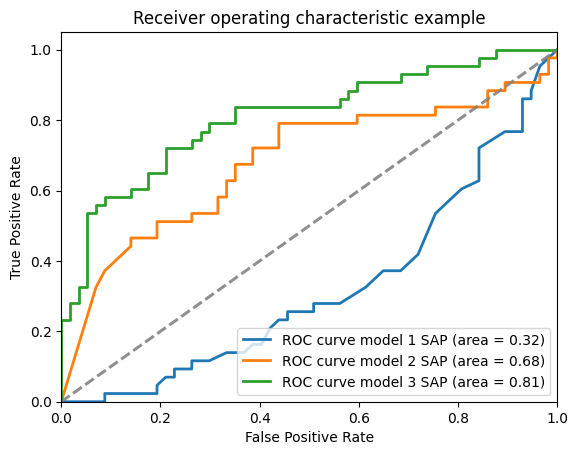

In [46]:
plt.figure()
lw = 2
    
for model in 1, 2, 3:
    fpr, tpr, _ = roc_curve(df_train_small.has_sap, df_train_small[f"y{model}"])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve model {model} SAP (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()